#  Implementation of Adam Optimizer on Fashion MNIST model

In [1]:
from fashionmnist_model import FMM
import tensorflow as tf

In [2]:
# Load the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [3]:
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [4]:
optimizer = tf.keras.optimizers.Adam()

In [5]:
# Create and compile the model with the optimizer
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with Adam optimizer...
Epoch 1/30


2024-02-22 21:45:25.490856: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 4s 5ms/step - loss: 0.5197 - accuracy: 0.8182 - val_loss: 0.4437 - val_accuracy: 0.8477
Epoch 2/30
750/750 [==============================] - 4s 6ms/step - loss: 0.3837 - accuracy: 0.8599 - val_loss: 0.3565 - val_accuracy: 0.8704
Epoch 3/30
750/750 [==============================] - 5s 6ms/step - loss: 0.3382 - accuracy: 0.8755 - val_loss: 0.3455 - val_accuracy: 0.8758
Epoch 4/30
750/750 [==============================] - 4s 5ms/step - loss: 0.3158 - accuracy: 0.8837 - val_loss: 0.3523 - val_accuracy: 0.8720
Epoch 5/30
750/750 [==============================] - 4s 6ms/step - loss: 0.2934 - accuracy: 0.8909 - val_loss: 0.3267 - val_accuracy: 0.8803
Epoch 6/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2779 - accuracy: 0.8965 - val_loss: 0.3340 - val_accuracy: 0.8802
Epoch 7/30
750/750 [==============================] - 4s 6ms/step - loss: 0.2656 - accuracy: 0.8999 - val_loss: 0.3368 - val_accuracy: 0.8821
Epoch 8/30
750/75

313/313 - 1s - loss: 0.4216 - accuracy: 0.8930 - 916ms/epoch - 3ms/step

Training accuracy : 0.9538124799728394
Validation accuracy : 0.8924999833106995
Loss : 0.42161324620246887
Accuracy : 0.8930000066757202



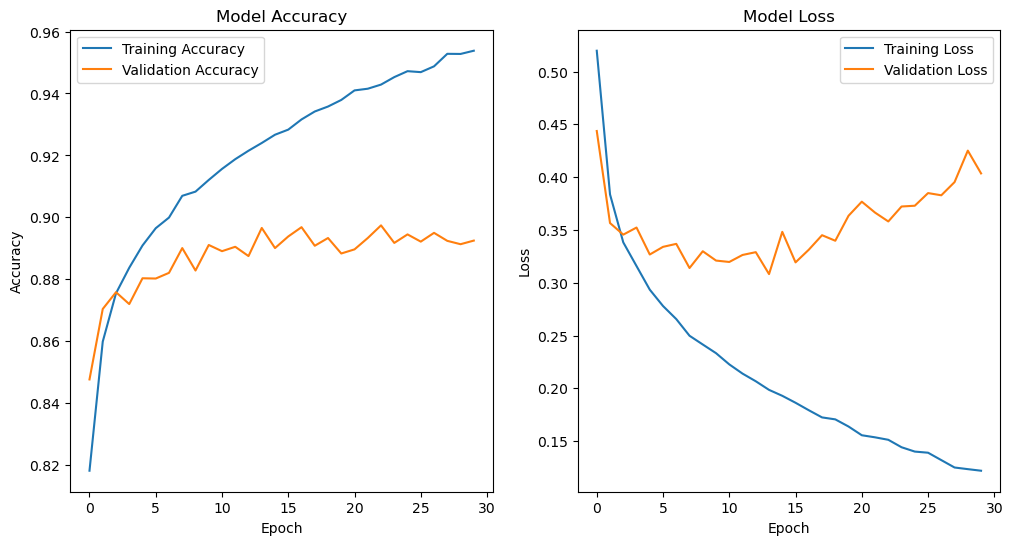

In [6]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

# Hyperparameter tunning

In [7]:
# ! pip install -U "ray[data,train,tune,serve]"

In [8]:
import ray
from ray import tune, train

In [9]:
ray.init()

2024-02-22 21:47:48,929	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [10]:
# Define a function to train the model
def train_model(config):
    from fashionmnist_model import FMM
    import tensorflow as tf
    
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=config["learning_rate"],
        # beta_1=config["beta_1"],
        # beta_2=config["beta_2"],
        # epsilon=config["epsilon"],
        # weight_decay=config["weight_decay"],
    )

    model = FMM.get_model()
    history = FMM.compile_and_train(
        model, X_train, y_train, optimizer, batch_size=64
    )
    
    loss, accuracy, _, _ = FMM.evaluate(model, X_test, y_test, history)

    train.report({"accuracy": accuracy, "loss": loss, **config})

In [11]:
search_space = { 
    "learning_rate": tune.grid_search([0.001, 0.0005, 0.0001]),
    # "beta_1": tune.grid_search([0.9, 0.95, 0.99]),
    # "beta_2": tune.grid_search([0.999, 0.9999]),
    # "epsilon": tune.grid_search([1e-8, 1e-7, 1e-6]),
    # "weight_decay": tune.grid_search([1e-6, 1e-5, 1e-4]),
}

In [12]:
# Run hyperparameter tuning
analysis = tune.run(
    train_model,
    config=search_space,
    metric="accuracy",
    mode="max",
)

2024-02-22 21:47:51,832	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
(raylet) [2024-02-22 21:47:57,829 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9079566336; capacity: 245107195904. Object creation will fail if spilling is required.


(raylet) [2024-02-22 21:48:07,885 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9076289536; capacity: 245107195904. Object creation will fail if spilling is required.
(train_model pid=71470) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(train_model pid=71470) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(train_model pid=71470) 2024-02-22 21:48:14.295169: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(train_model pid=71470) Epoch 1/30
 71/750 [=>............................] - ETA: 7s - loss: 1.0805 - accuracy: 0.6433


(raylet) [2024-02-22 21:48:17,929 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9076068352; capacity: 245107195904. Object creation will fail if spilling is required.


441/750 [================>.............] - ETA: 2s - loss: 0.9102 - accuracy: 0.7139
(train_model pid=71469) Epoch 1/30 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
442/750 [================>.............] - ETA: 2s - loss: 0.5714 - accuracy: 0.7992
(train_model pid=71470) Epoch 2/30
  1/750 [..............................] - ETA: 5s - loss: 0.3684 - accuracy: 0.8750
(train_model pid=71468) Epoch 2/30
698/750 [==========================>...] - ETA: 0s - loss: 0.5554 - accuracy: 0.8098


(train_model pid=71469) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 2x across cluster]
(train_model pid=71469) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`. [repeated 2x across cluster]
(train_model pid=71469) 2024-02-22 21:48:15.501744: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz [repeated 2x across cluster]
(raylet) [2024-02-22 21:48:27,937 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9324412928; capacity: 245107195904. Object creation will fail if spilling is required.


637/750 [========================>.....] - ETA: 0s - loss: 0.3885 - accuracy: 0.8610 [repeated 3x across cluster]
(train_model pid=71469) Epoch 2/30
114/750 [===>..........................] - ETA: 4s - loss: 0.4034 - accuracy: 0.8583
(train_model pid=71470) Epoch 3/30
131/750 [====>.........................] - ETA: 4s - loss: 0.3434 - accuracy: 0.8782 [repeated 3x across cluster]
(train_model pid=71470) Epoch 4/30 [repeated 3x across cluster]
339/750 [============>.................] - ETA: 2s - loss: 0.3547 - accuracy: 0.8732 [repeated 2x across cluster]


(raylet) [2024-02-22 21:48:37,944 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9323413504; capacity: 245107195904. Object creation will fail if spilling is required.


138/750 [====>.........................] - ETA: 3s - loss: 0.3747 - accuracy: 0.8691
(train_model pid=71469) Epoch 5/30 [repeated 5x across cluster]
  1/750 [..............................] - ETA: 3s - loss: 0.4808 - accuracy: 0.8438
(train_model pid=71470) Epoch 6/30
 38/750 [>.............................] - ETA: 4s - loss: 0.3853 - accuracy: 0.8643
(train_model pid=71468) Epoch 6/30
 93/750 [==>...........................] - ETA: 3s - loss: 0.2993 - accuracy: 0.8884


(raylet) [2024-02-22 21:48:47,957 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9323397120; capacity: 245107195904. Object creation will fail if spilling is required.


 53/750 [=>............................] - ETA: 4s - loss: 0.2757 - accuracy: 0.8986 [repeated 2x across cluster]
(train_model pid=71469) Epoch 6/30
(train_model pid=71470) Epoch 7/30
573/750 [=====================>........] - ETA: 1s - loss: 0.3426 - accuracy: 0.8784
(train_model pid=71469) Epoch 7/30 [repeated 2x across cluster]
575/750 [======================>.......] - ETA: 1s - loss: 0.2619 - accuracy: 0.9037


(raylet) [2024-02-22 21:48:57,962 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9328451584; capacity: 245107195904. Object creation will fail if spilling is required.


150/750 [=====>........................] - ETA: 5s - loss: 0.2520 - accuracy: 0.9058
(train_model pid=71469) Epoch 8/30 [repeated 3x across cluster]
562/750 [=====================>........] - ETA: 1s - loss: 0.2585 - accuracy: 0.9039
(train_model pid=71468) Epoch 9/30 [repeated 2x across cluster]
177/750 [======>.......................] - ETA: 3s - loss: 0.2356 - accuracy: 0.9073


(raylet) [2024-02-22 21:49:07,969 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9327538176; capacity: 245107195904. Object creation will fail if spilling is required.


 40/750 [>.............................] - ETA: 5s - loss: 0.3269 - accuracy: 0.8844
(train_model pid=71470) Epoch 10/30 [repeated 2x across cluster]
 25/750 [>.............................] - ETA: 4s - loss: 0.2217 - accuracy: 0.9112
(train_model pid=71469) Epoch 10/30 [repeated 2x across cluster]
 57/750 [=>............................] - ETA: 4s - loss: 0.2221 - accuracy: 0.9164


(raylet) [2024-02-22 21:49:17,985 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9327349760; capacity: 245107195904. Object creation will fail if spilling is required.


582/750 [======================>.......] - ETA: 1s - loss: 0.3044 - accuracy: 0.8917
(train_model pid=71469) Epoch 11/30 [repeated 3x across cluster]
356/750 [=============>................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8936
(train_model pid=71469) Epoch 12/30 [repeated 3x across cluster]


(raylet) [2024-02-22 21:49:28,087 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9326809088; capacity: 245107195904. Object creation will fail if spilling is required.


264/750 [=========>....................] - ETA: 3s - loss: 0.2906 - accuracy: 0.8974
(train_model pid=71469) Epoch 13/30 [repeated 3x across cluster]
269/750 [=========>....................] - ETA: 3s - loss: 0.2111 - accuracy: 0.9208
(train_model pid=71468) Epoch 14/30 [repeated 2x across cluster]
 67/750 [=>............................] - ETA: 5s - loss: 0.1928 - accuracy: 0.9282


(raylet) [2024-02-22 21:49:38,187 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9326600192; capacity: 245107195904. Object creation will fail if spilling is required.


120/750 [===>..........................] - ETA: 4s - loss: 0.2024 - accuracy: 0.9277 [repeated 2x across cluster]
(train_model pid=71469) Epoch 14/30
(train_model pid=71470) Epoch 15/30
577/750 [======================>.......] - ETA: 1s - loss: 0.1944 - accuracy: 0.9276


(raylet) [2024-02-22 21:49:48,286 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9326465024; capacity: 245107195904. Object creation will fail if spilling is required.


(train_model pid=71469) Epoch 15/30 [repeated 2x across cluster]
559/750 [=====================>........] - ETA: 1s - loss: 0.2715 - accuracy: 0.9027
(train_model pid=71469) Epoch 16/30 [repeated 3x across cluster]
553/750 [=====================>........] - ETA: 1s - loss: 0.1895 - accuracy: 0.9289
(train_model pid=71469) Epoch 17/30 [repeated 3x across cluster]


(raylet) [2024-02-22 21:49:58,385 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9326014464; capacity: 245107195904. Object creation will fail if spilling is required.


536/750 [====================>.........] - ETA: 1s - loss: 0.1787 - accuracy: 0.9329 [repeated 4x across cluster]
(train_model pid=71469) Epoch 18/30 [repeated 3x across cluster]
548/750 [====================>.........] - ETA: 1s - loss: 0.1768 - accuracy: 0.9343 [repeated 3x across cluster]


(raylet) [2024-02-22 21:50:08,484 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9325207552; capacity: 245107195904. Object creation will fail if spilling is required.


(train_model pid=71469) Epoch 19/30 [repeated 3x across cluster]
267/750 [=========>....................] - ETA: 2s - loss: 0.1584 - accuracy: 0.9412
(train_model pid=71469) Epoch 20/30 [repeated 3x across cluster]
  1/750 [..............................] - ETA: 5s - loss: 0.1331 - accuracy: 0.9375


(raylet) [2024-02-22 21:50:18,580 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9325023232; capacity: 245107195904. Object creation will fail if spilling is required.


222/750 [=======>......................] - ETA: 3s - loss: 0.2431 - accuracy: 0.9129
(train_model pid=71469) Epoch 21/30 [repeated 3x across cluster]
153/750 [=====>........................] - ETA: 3s - loss: 0.2394 - accuracy: 0.9151
(train_model pid=71470) Epoch 22/30 [repeated 2x across cluster]
491/750 [==================>...........] - ETA: 1s - loss: 0.1519 - accuracy: 0.9445 [repeated 2x across cluster]


(raylet) [2024-02-22 21:50:28,584 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9324687360; capacity: 245107195904. Object creation will fail if spilling is required.


151/750 [=====>........................] - ETA: 3s - loss: 0.1458 - accuracy: 0.9462
(train_model pid=71470) Epoch 23/30 [repeated 3x across cluster]
148/750 [====>.........................] - ETA: 3s - loss: 0.1329 - accuracy: 0.9488
(train_model pid=71470) Epoch 24/30 [repeated 3x across cluster]
495/750 [==================>...........] - ETA: 1s - loss: 0.2329 - accuracy: 0.9162 [repeated 2x across cluster]


(raylet) [2024-02-22 21:50:38,684 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9324621824; capacity: 245107195904. Object creation will fail if spilling is required.


139/750 [====>.........................] - ETA: 3s - loss: 0.1267 - accuracy: 0.9504
(train_model pid=71470) Epoch 25/30 [repeated 3x across cluster]
135/750 [====>.........................] - ETA: 3s - loss: 0.1315 - accuracy: 0.9515 [repeated 2x across cluster]
(train_model pid=71470) Epoch 26/30 [repeated 3x across cluster]
 32/750 [>.............................] - ETA: 3s - loss: 0.1126 - accuracy: 0.9575


(raylet) [2024-02-22 21:50:48,780 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9324322816; capacity: 245107195904. Object creation will fail if spilling is required.


145/750 [====>.........................] - ETA: 3s - loss: 0.2229 - accuracy: 0.9237 [repeated 2x across cluster]
(train_model pid=71470) Epoch 27/30 [repeated 3x across cluster]
588/750 [======================>.......] - ETA: 0s - loss: 0.1255 - accuracy: 0.9545
(train_model pid=71469) Epoch 27/30
103/750 [===>..........................] - ETA: 4s - loss: 0.2255 - accuracy: 0.9217
(train_model pid=71470) Epoch 28/30
 30/750 [>.............................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9490 [repeated 2x across cluster]


(raylet) [2024-02-22 21:50:58,879 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9324015616; capacity: 245107195904. Object creation will fail if spilling is required.


285/750 [==========>...................] - ETA: 2s - loss: 0.1269 - accuracy: 0.9512 [repeated 3x across cluster]
(train_model pid=71469) Epoch 28/30 [repeated 2x across cluster]
741/750 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9524
(train_model pid=71469) Epoch 29/30 [repeated 3x across cluster]
 26/750 [>.............................] - ETA: 4s - loss: 0.1070 - accuracy: 0.9597 [repeated 2x across cluster]


(raylet) [2024-02-22 21:51:08,978 E 71384 512606] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-22_21-47-43_646208_70494 is over 95% full, available space: 9323384832; capacity: 245107195904. Object creation will fail if spilling is required.


746/750 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9261 [repeated 2x across cluster]
(train_model pid=71469) Epoch 30/30 [repeated 3x across cluster]
223/750 [=======>......................] - ETA: 3s - loss: 0.1180 - accuracy: 0.9568


Trial name,accuracy,learning_rate,loss
train_model_effdd_00000,0.8847,0.001,0.437732
train_model_effdd_00001,0.8847,0.0005,0.429427
train_model_effdd_00002,0.882,0.0001,0.334357


(train_model pid=71470) 313/313 - 1s - loss: 0.3344 - accuracy: 0.8820 - 1s/epoch - 4ms/step
(train_model pid=71470) 
(train_model pid=71470) Training accuracy : 0.9259374737739563
(train_model pid=71470) Validation accuracy : 0.890749990940094
(train_model pid=71470) Loss : 0.3343566358089447
(train_model pid=71470) Accuracy : 0.8820000290870667
(train_model pid=71470) 
617/750 [=======================>......] - ETA: 0s - loss: 0.1184 - accuracy: 0.9568 [repeated 3x across cluster]


2024-02-22 21:51:13,165	INFO tune.py:1042 -- Total run time: 201.33 seconds (194.99 seconds for the tuning loop).


451/750 [=================>............] - ETA: 1s - loss: 0.1177 - accuracy: 0.9574


In [13]:
ray.shutdown()

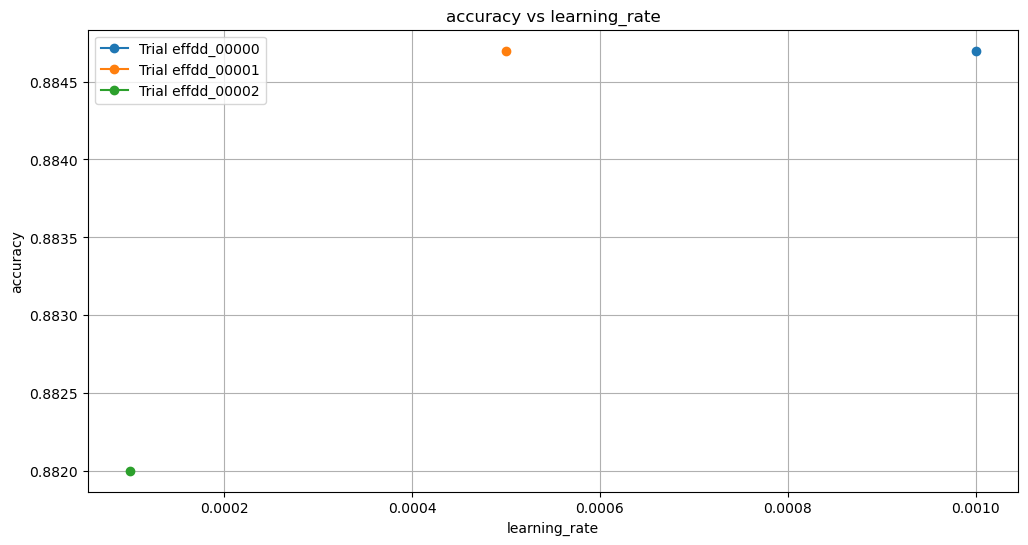

In [14]:
FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [15]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])

Best hyperparameters: {'learning_rate': 0.001}
Best accuracy: 0.8847000002861023


In [16]:
optimizer = tf.keras.optimizers.Adam(**best_config)
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with Adam optimizer...
Epoch 1/30
750/750 [==============================] - 6s 7ms/step - loss: 0.5195 - accuracy: 0.8169 - val_loss: 0.4151 - val_accuracy: 0.8487
Epoch 2/30
750/750 [==============================] - 5s 7ms/step - loss: 0.3760 - accuracy: 0.8634 - val_loss: 0.3625 - val_accuracy: 0.8657
Epoch 3/30
750/750 [==============================] - 5s 7ms/step - loss: 0.3336 - accuracy: 0.8780 - val_loss: 0.3664 - val_accuracy: 0.8637
Epoch 4/30
750/750 [==============================] - 6s 8ms/step - loss: 0.3107 - accuracy: 0.8846 - val_loss: 0.3407 - val_accuracy: 0.8751
Epoch 5/30
750/750 [==============================] - 6s 7ms/step - loss: 0.2923 - accuracy: 0.8916 - val_loss: 0.3423 - val_accuracy: 0.8777
Epoch 6/30
750/750 [==============================] - 6s 7ms/step - loss: 0.2776 - accuracy: 0.8966 - val_loss: 0.3371 - val_accuracy: 0.8768
Epoch 7/30
750/750 [==============================] - 5s 7ms/step - loss: 0.2645 - accuracy: 0.9014 - val_loss: 0.31

313/313 - 1s - loss: 0.4254 - accuracy: 0.8887 - 891ms/epoch - 3ms/step

Training accuracy : 0.9544166922569275
Validation accuracy : 0.8959166407585144
Loss : 0.42544302344322205
Accuracy : 0.888700008392334



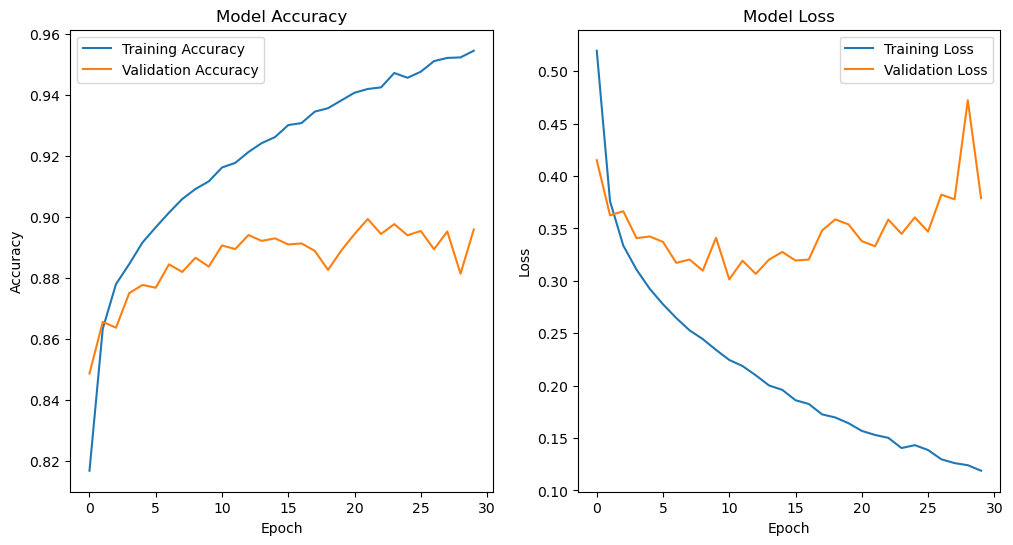

In [17]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)